# MTE 544 Report

|Stephen Wang|Ajit Rakhra|Howard Dong|
|:-:|:-:|:-:|
|x2274wan|a3rakhra|h53dong|
|20821034|20832703|20847639|

Station 3, Robot 4 on Fri Nov 17 at 8:30 AM

## Understanding the Extended Kalman Filter

The principle of the EKF is that if the motion model describing how the previous robot state evolves to the next is nonlinear, then the covariance matrix of the state variables, modeled as random Gaussian variables, can be calculated using the Jacobian of the motion model, which linearizes the model about the mean of the estimated state.
The same goes for the measurement model.
This Bayesian filter is aptly named extended Kalman filter because if the motion model and measurement model were linear, the EKF is identical to the original linear Kalman filter.

Here is the motion model of the TurtleBots.

$$
\bar{\xi}_{k+1} = f(\xi_k, u)
$$
$$
\begin{bmatrix}
\bar{x}_{k+1} \\
\bar{y}_{k+1} \\
\bar{\theta}_{k+1} \\
\bar{\omega}_{k+1} \\
\bar{v}_{k+1} \\
\bar{\dot{v}}_{k+1}
\end{bmatrix}
=
\begin{bmatrix}
f_1(\xi_{k+1}) \\
f_2(\xi_{k+1}) \\
f_3(\xi_{k+1}) \\
f_4(\xi_{k+1}) \\
f_5(\xi_{k+1}) \\
f_6(\xi_{k+1}) \\
\end{bmatrix}
=
\begin{bmatrix}
x_k + v_k \cdot \cos{\theta_k} \cdot \Delta t \\
y_k + v_k \cdot \sin{\theta_k} \cdot \Delta t \\
\theta_k + \omega_k \cdot \Delta t \\
\omega_k \\
v_k + \dot{v_k} \cdot \Delta t \\
\dot{v}_k
\end{bmatrix}
$$

Where $v$ is the speed in the robot heading, in another words the X axis in the robot frame.
The effect of control input $u$ is ignored in the model and it's assumed that within a $\Delta t$, the change in the robot state is very small so only the inertial effects are accounted for.

The Jacobian matrix can then be calculated as
$$
J_{ij}^{(k)} = \frac{\partial f_i}{\partial \xi^{(j)}} \biggm\lvert_{\xi=\xi_k}
$$
Where $J_{ij}^{(k)}$ is the element in row $i$ and column $j$ of the Jacobian matrix at time step $k$.
Only one examples in the derivation is shown below for brevity.
$$
\frac{\partial f_1}{\partial \xi^{(3)}_k} = \frac{\partial}{\partial \theta_k} (x_k + v_k \cdot \cos{\theta_k} \cdot \Delta t) = -\sin{\theta_k} \cdot v_k \cdot \Delta t
$$
Once $\theta_k$ and $v_k$ are substituted with their estimated means, $J_{13}^{(k)}\cdot \theta_k$ can approximate the original $f_1(\theta_k)$ well, near $\theta_k$.
This approximation can then be used to determine the covariance, in other words the preciseness, of the random variable $\theta$ at the next iteration to itself, and to other elements of $\xi$.

The measurement model of the TurtleBot is derived as follows.

$$
\bar{z}_{k+1} = h(\bar{\xi}_{k+1})
$$
$$
\begin{bmatrix}
v'_{k+1} \\
\omega'_{k+1} \\
a'_{x, k+1} \\
a'_{y, k+1} \\
\end{bmatrix}
=
\begin{bmatrix}
h_1(\bar{\xi}_{k+1}) \\
h_2(\bar{\xi}_{k+1}) \\
h_3(\bar{\xi}_{k+1}) \\
h_4(\bar{\xi}_{k+1}) \\
\end{bmatrix}
=
\begin{bmatrix}
\bar{v}_{k+1} \\
\bar{\omega}_{k+1} \\
\bar{\dot{v}}_{k+1} \\
\bar{v}_{k+1} \cdot \bar{\omega}_{k+1} \\
\end{bmatrix}
$$

Where $v'_{k+1}$ is the expected speed in the robot frame X axis, $a'_{x, k+1}$ is the expected acceleration in the expected odom/global frame X axis measurement at step $k+1$, and $a'_{y, k+1}$ is the expected acceleration in the expected odom/global frame Y axis measurement at step $k+1$.

Similar to the Jacobian in the motion model, a partial derivative multiplied with the variable gives a good approximation to the function $h(\bar{\xi}_{k+1})$.
One example is shown again for brevity.

$$
\frac{\partial h_4}{\partial \bar{\xi}^{(4)}_{k+1}} = \frac{\partial}{\partial \omega_{k+1}} (\bar{v}_{k+1} \cdot \bar{\omega}_{k+1}) = \bar{v}_{k+1}
$$

Now the approximation can be used to calculate Kalman gain.

In [2]:
%config InlineBackend.figure_formats = ["svg"]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [4]:
def load_csv(filename):
  data = pd.read_csv(filename)
  for c in data.columns:
    setattr(sys.modules["__main__"], c, data[c].to_numpy())
  globals()["t"] -= globals()["t"][0]

In [15]:
def plot_top():
  fig, axes = plt.subplots(1,4, figsize=(10,3))

  fig.tight_layout(pad=3)

  ax = axes[0]
  ax.plot(t, imu_ay, label="imu")
  ax.plot(t, kf_v * kf_omega, label="kf")
  ax.grid()
  ax.legend()
  ax.set_title(r"$a_y$")
  ax.set_xlabel("t (s)")

  ax = axes[1]
  ax.plot(t, imu_ax, label="imu")
  ax.plot(t, kf_vdot, label="kf")
  ax.grid()
  ax.legend()
  ax.set_title(r"$a_x$")
  ax.set_xlabel("t (s)")

  ax = axes[2]
  ax.plot(t, odom_x, label="odom")
  ax.plot(t, kf_x, label="kf")
  ax.grid()
  ax.legend()
  ax.set_title(r"$x$")
  ax.set_xlabel("t (s)")

  ax = axes[3]
  ax.plot(t, odom_y, label="odom")
  ax.plot(t, kf_y, label="kf")
  ax.grid()
  ax.legend()
  ax.set_title(r"$y$")
  ax.set_xlabel("t (s)")

In [17]:
def plot_bottom():
  fig, axes = plt.subplots(1, 3, figsize=(10, 3))
  fig.tight_layout(pad=3)

  ax = axes[0]
  ax.plot(t, odom_theta, label="odom")
  ax.plot(t, kf_theta, label="kf")
  ax.grid()
  ax.legend()
  ax.set_title(r"$\theta$")
  ax.set_xlabel("t (s)")

  ax = axes[1]
  ax.plot(t, odom_omega, label="odom")
  ax.plot(t, kf_omega, label="kf")
  ax.grid()
  ax.legend()
  ax.set_title(r"$\omega$")
  ax.set_xlabel("t (s)")

  ax = axes[2]
  ax.plot(odom_x, odom_y, label="odom")
  ax.plot(kf_x, kf_y, label="kf")
  ax.grid()
  ax.axis("scaled")
  ax.legend()
  ax.set_title(r"Trajectory")
  ax.set_xlabel("X")
  ax.set_ylabel("Y")

## Evaluation of EKF on TurtleBot3

During the lab, we set $Q = 0.5 I_6$ and $R = 0.5 I_4$.
The following figures plot the filter input from IMU measurements and Odom estimates against the filter output.

Experimenting with recovering the Odom v

In [8]:
import ipywidgets

In [50]:
# synthetic_mean = poly(t)
@ipywidgets.interact(
    a=ipywidgets.FloatSlider(min=-.006, max=0, value=-.0051, step=1e-4),
    b=ipywidgets.FloatSlider(min=.03, max=.13, value=.086, step=1e-3),
    c=ipywidgets.FloatSlider(min=-.1, max=.1, step=1e-3),
)
def fake_v(a, b, c):
  # synthetic_mean = 0.06*t
  print(a, b, c)
  plateau_t = 6
  slope = .07
  # synthetic_mean = slope*t * (t<plateau_t) + slope*plateau_t * (t>plateau_t)
  synthetic_mean = a*t**2 + b*t + c
  plt.plot(t, synthetic_mean, label="synthetic mean")
  plt.plot(t, kf_v, label="kf output v")
  plt.plot(t, synthetic_mean + (np.random.random(t.shape)-0.5)*.15, label="synthetic")
  plt.legend()

interactive(children=(FloatSlider(value=-0.0051, description='a', max=0.0, min=-0.006, step=0.0001), FloatSlid…

Original plot

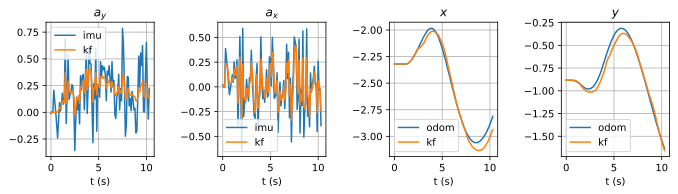

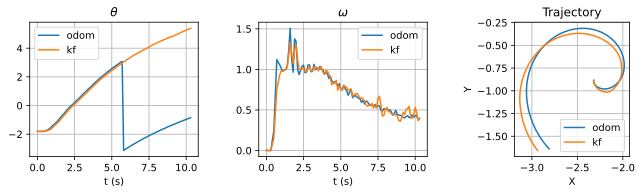

In [94]:
load_csv("robotPose.line.csv")
plot_top()
plot_bottom()

New plot obtained by offline simulation

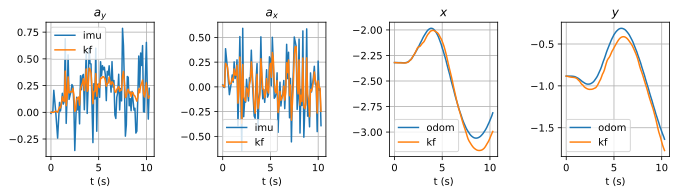

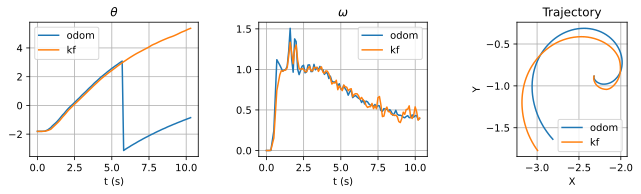

In [95]:
load_csv("kf_q0.5_r0.5.csv")
plot_top()
plot_bottom()

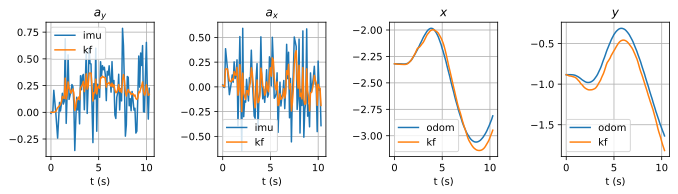

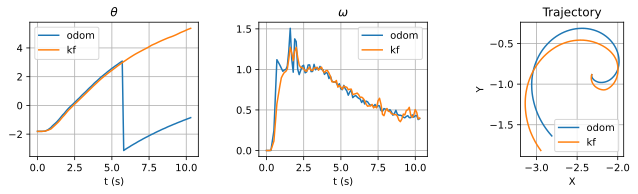

In [96]:
load_csv("kf_q0.2_r0.5.csv")
plot_top()
plot_bottom()

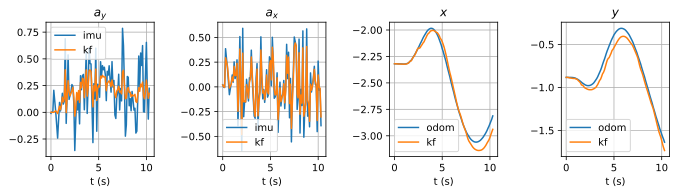

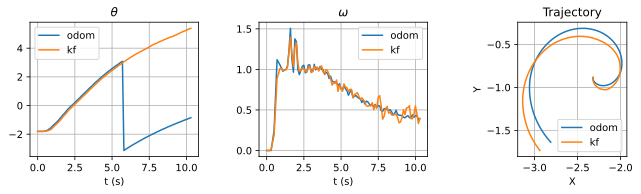

In [97]:
load_csv("kf_q0.5_r0.2.csv")
plot_top()
plot_bottom()

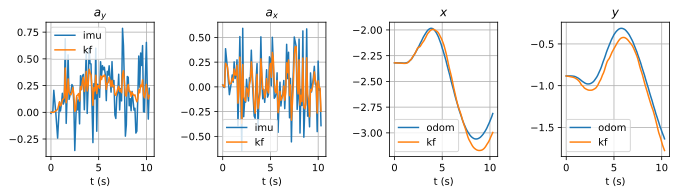

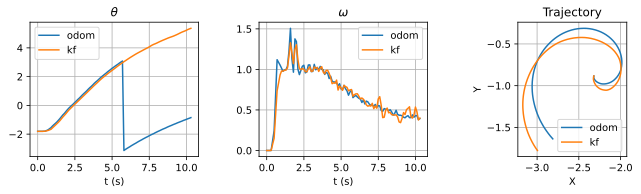

In [98]:
load_csv("kf_q0.2_r0.2.csv")
plot_top()
plot_bottom()

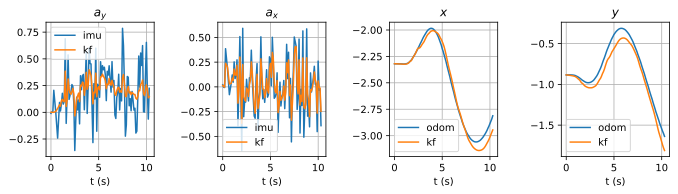

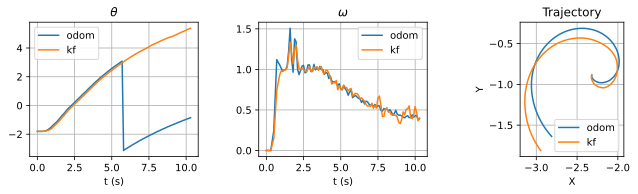

In [99]:
load_csv("kf_q0.8_r0.8.csv")
plot_top()
plot_bottom()

Plot of original point navigation

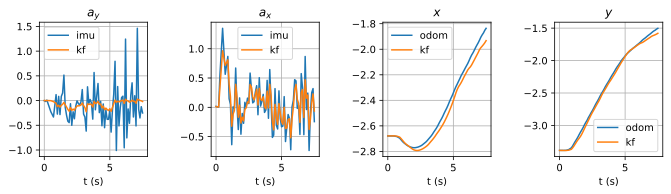

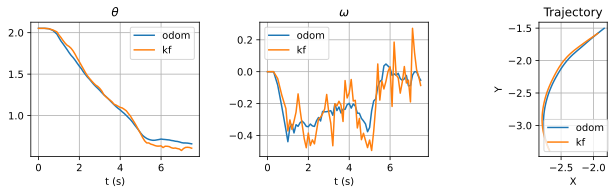

In [92]:
load_csv("robotPose.point.csv")
plot_top()
plot_bottom()

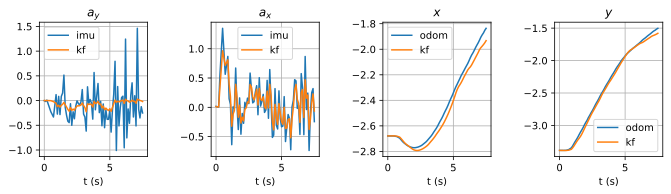

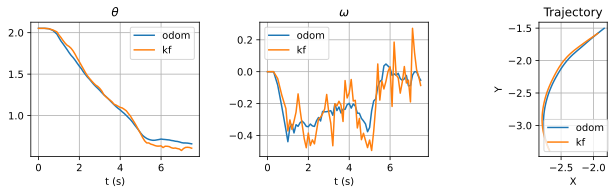

In [93]:
plot_top()
plot_bottom()

Plots of simulated point navigation

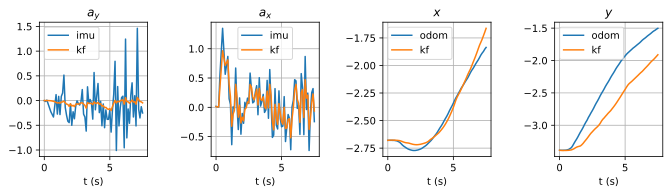

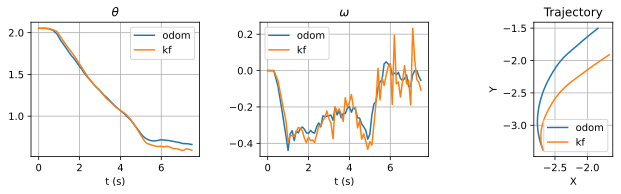

In [67]:
load_csv("kf_q0.5_r0.5_point.csv")
plot_top()
plot_bottom()

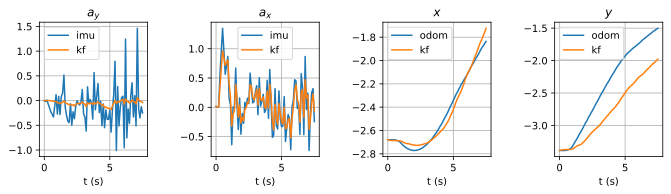

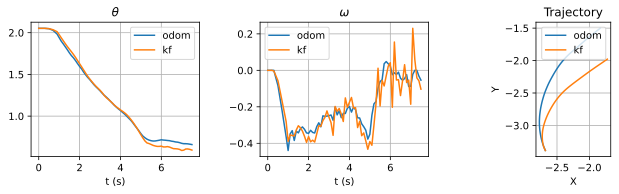

In [68]:
load_csv("kf_q0.2_r0.2_point.csv")
plot_top()
plot_bottom()

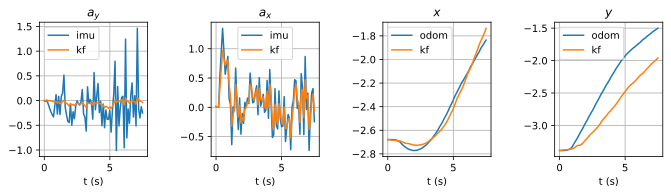

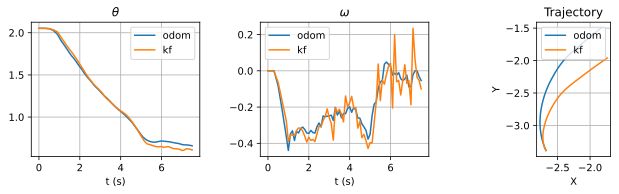

In [69]:
load_csv("kf_q0.8_r0.8_point.csv")
plot_top()
plot_bottom()

Discussion on the differences between different values of R and Q:
???